https://math.stackexchange.com/questions/1792539/how-do-we-convert-annual-growth-rate-to-daily-growth-rate
https://stackoverflow.com/questions/13556703/array-elementwise-operations
https://matplotlib.org/stable/tutorials/colors/colormaps.html
https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
https://syscoin.org/syscoin3_whitepaper_summary.pdf
https://messari.io/asset/syscoin/chart/sply-circ

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin, minimize

In [2]:
tx_fee = pd.read_csv('../resources/ETHTransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])
date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

In [3]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021

In [4]:
tx_fee.loc[100]

date          11/7/2015
timestamp    1446854400
tx_fee          32.0799
date_time    2015-11-07
Name: 100, dtype: object

In [5]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021
MAX_COINS = 888000000
DAYS_IN_YEAR = 365
ANNUAL_INFLATION = 0.05
DAILY_PERCENTAGE_GRWTH = (1+ANNUAL_INFLATION)**(1/DAYS_IN_YEAR)
LAST_DATE = '2021-06-28 00:00:00'
START_DATE = '2015-11-07 00:00:00'

In [6]:
def supplyNYears(A,t):
    return A*(1.05)**t

def supplyNDays(A,t):
    daysInYr = 366 if isLeapYear(getDate(t, strt_date = LAST_DATE).year) else 365
    return A*(1.05)**(t/365)

In [7]:
def isLeapYear(yr):
    return bool((yr-2000) % 4 == 0) 

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=t) 

In [8]:
N = 365
STRT_DATE = '2022-01-01 00:00:00'
STRT_SUPPLY = 554103161
STRT_YR = 2019
DEFLATION = 0.05
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 23.45
NUM_DAILY_BLOCKS = 24*60

def gen_block_rewards(strt_date = STRT_DATE,
                      strt_supply = STRT_SUPPLY,
                      ini_blk_reward = INITIAL_BLK_REWARD,
                      n = N,
                      deflation = DEFLATION,
                      num_daily_blocks = NUM_DAILY_BLOCKS,
                      nevm_rewards = None,
                      pow_rewards = None):
    
    STRT_YR = datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S").year
    blk_rewards = [ini_blk_reward]
    dates = np.array([getDate(t, strt_date = strt_date) for t in range(0,n)])
    da = np.array([dates.flatten()[t].day for t in range(0,n)])
    mo = np.array([dates.flatten()[t].month for t in range(0,n)])
    yr = np.array([dates.flatten()[t].year for t in range(0,n)])

    rewards = np.repeat(0.0,n)
    rewards[0] = blk_rewards[0]

    for k in range(1, n):
        diff_yr = yr[k] - yr[k-1]
        diff_mo = mo[k] - mo[k-1]
        rewards[k] = blk_rewards[len(blk_rewards)-1]
        
        if diff_mo == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
        
        if diff_yr == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
            blk_rewards.append(blk_reward - deflation*blk_reward)

    daily_rewards = rewards*num_daily_blocks       
            
    df = pd.DataFrame({'dates':dates.flatten(),
                       'yr':yr.flatten(),
                       'mo':mo.flatten(),
                       'da':da.flatten(),
                       'blk_reward':rewards,
                       'daily_rewards':daily_rewards,
                       'supply':strt_supply+np.cumsum(daily_rewards)})
    
    if (nevm_rewards != None): 
        df.insert(loc=5, column='nevm_rewards', value=nevm_rewards)

    if (pow_rewards != None): 
        df.insert(loc=6, column='pow_rewards', value=pow_rewards)  
        
    if (nevm_rewards != None) & (pow_rewards != None):
        rewards = rewards + np.repeat(nevm_rewards,n)
        daily_rewards = rewards*num_daily_blocks 
        df = df.assign(daily_rewards=daily_rewards)
          
    return df

In [9]:
N = 365*4 + 1

supply = [INITIAL_SYS_SUPPLY]
for t in range(1,N): supply.append(supply[-1]*DAILY_PERCENTAGE_GRWTH)
supply = np.array(supply)
dates = np.array([getDate(t) for t in range(0,N)])

df = pd.DataFrame({'dates':dates.flatten(), 'inflate':supply.flatten()})
df['inflate'].values[-1]

747209001.3896676

In [10]:
# Jun 03 2019 (start)
# supply = 554103161

# Aug 23, 2021 (end) 
# supply 617746652

In [11]:
INDEX = 812
SUPPLY_AT_INDEX = 617746652

def objective_function(alpha):
    
    pow_df = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = alpha*38.5,
                           n = N)
                  
    return abs(SUPPLY_AT_INDEX - pow_df['supply'].iloc[INDEX])

In [12]:
ALPHA_INIT = 1.4872300387520823
result = minimize(objective_function, ALPHA_INIT, method='SLSQP', options={'maxiter': 1000})
alpha_hat = result.x[0]
alpha_hat

1.4591208198611727

In [13]:
alpha_hat = 1.4872300387520823
N = 943
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = alpha_hat*38.5

pow_df = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N)

pow_df.iloc[810:815]

,dates,yr,mo,da,blk_reward,daily_rewards,supply
810,2021-08-21,2021,8,21,51.675667,74412.960097,6.175978e+08
811,2021-08-22,2021,8,22,51.675667,74412.960097,6.176722e+08
812,2021-08-23,2021,8,23,51.675667,74412.960097,6.177466e+08
813,2021-08-24,2021,8,24,51.675667,74412.960097,6.178211e+08
814,2021-08-25,2021,8,25,51.675667,74412.960097,6.178955e+08


In [14]:
pow_df.tail(3)

,dates,yr,mo,da,blk_reward,daily_rewards,supply
940,2021-12-29,2021,12,29,51.675667,74412.960097,6.272715e+08
941,2021-12-30,2021,12,30,51.675667,74412.960097,6.273459e+08
942,2021-12-31,2021,12,31,51.675667,74412.960097,6.274203e+08


In [15]:
N = 12*365+3
STRT_DATE = '2022-01-01 00:00:00'
STRT_SUPPLY = pow_df['supply'].values[-1]
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 23.45

nevm_lwr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 5.27)

In [16]:
N = 12*365+3
STRT_DATE = '2022-01-01 00:00:00'
STRT_SUPPLY = pow_df['supply'].values[-1]
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = pow_df['blk_reward'].values[-1]

nevm_med = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [17]:
N = 12*365+3
STRT_DATE = '2022-01-01 00:00:00'
STRT_SUPPLY = pow_df['supply'].values[-1]
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 46.9

nevm_upr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [18]:
nevm_df = nevm_lwr.iloc[:, [0,1,2,3]]
nevm_df.insert(loc=4, column='blk_reward_lwr', value=nevm_lwr['blk_reward'].values)
nevm_df.insert(loc=5, column='nevm_rewards_lwr', value=nevm_lwr['nevm_rewards'].values)
nevm_df.insert(loc=6, column='pow_rewards_lwr', value=nevm_lwr['pow_rewards'].values)
nevm_df.insert(loc=7, column='daily_rewards_lwr', value=nevm_lwr['daily_rewards'].values)
nevm_df.insert(loc=8, column='supply_lwr', value=nevm_lwr['supply'].values)

nevm_df.insert(loc=9, column='blk_reward_upr', value=nevm_upr['blk_reward'].values)
nevm_df.insert(loc=10, column='nevm_rewards_upr', value=nevm_upr['nevm_rewards'].values)
nevm_df.insert(loc=11, column='pow_rewards_upr', value=nevm_upr['pow_rewards'].values)
nevm_df.insert(loc=12, column='daily_rewards_upr', value=nevm_upr['daily_rewards'].values)
nevm_df.insert(loc=13, column='supply_upr', value=nevm_upr['supply'].values)

In [19]:
nevm_lwr.head(10)

,dates,yr,mo,da,blk_reward,nevm_rewards,pow_rewards,daily_rewards,supply
0,2022-01-01,2022,1,1,34.725,10.55,5.27,65196.0,6.274703e+08
1,2022-01-02,2022,1,2,34.725,10.55,5.27,65196.0,6.275203e+08
2,2022-01-03,2022,1,3,34.725,10.55,5.27,65196.0,6.275703e+08
3,2022-01-04,2022,1,4,34.725,10.55,5.27,65196.0,6.276203e+08
4,2022-01-05,2022,1,5,34.725,10.55,5.27,65196.0,6.276704e+08
5,2022-01-06,2022,1,6,34.725,10.55,5.27,65196.0,6.277204e+08
6,2022-01-07,2022,1,7,34.725,10.55,5.27,65196.0,6.277704e+08
7,2022-01-08,2022,1,8,34.725,10.55,5.27,65196.0,6.278204e+08
8,2022-01-09,2022,1,9,34.725,10.55,5.27,65196.0,6.278704e+08
9,2022-01-10,2022,1,10,34.725,10.55,5.27,65196.0,6.279204e+08


In [20]:
nevm_upr.head(5)

,dates,yr,mo,da,blk_reward,nevm_rewards,pow_rewards,daily_rewards,supply
0,2022-01-01,2022,1,1,58.175,10.55,10.55,98964.0,6.275041e+08
1,2022-01-02,2022,1,2,58.175,10.55,10.55,98964.0,6.275879e+08
2,2022-01-03,2022,1,3,58.175,10.55,10.55,98964.0,6.276716e+08
3,2022-01-04,2022,1,4,58.175,10.55,10.55,98964.0,6.277554e+08
4,2022-01-05,2022,1,5,58.175,10.55,10.55,98964.0,6.278392e+08


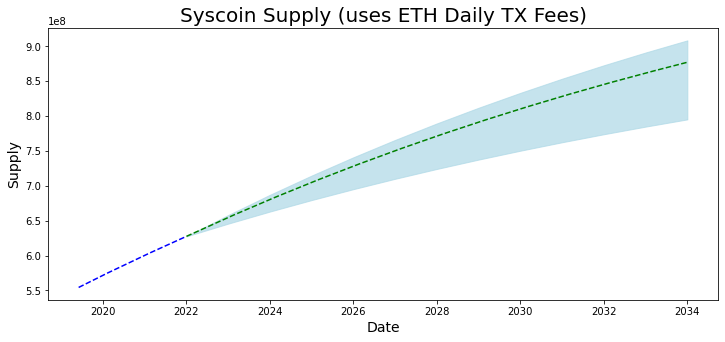

In [40]:
fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pow_df['dates'].values, pow_df['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_df['dates'].values, nevm_df['supply_lwr'].values, nevm_df['supply_upr'].values, alpha=0.7, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
plt.ylabel("Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)
fig.savefig('../img/syscoin_daily_supply.png')

In [22]:
supplyNDays(INITIAL_SYS_SUPPLY,365)

645467229.3615

In [23]:
supplyNYears(INITIAL_SYS_SUPPLY,1)

645467229.3615

In [24]:
def f(t_x,n_coins_y):
    n_supply = supplyNDays(INITIAL_SYS_SUPPLY,t_x)
    val = 1
    if(n_coins_y < 0.1*n_supply):
        val = 4
    elif (n_coins_y >= 0.1*n_supply and n_coins_y < 0.25*n_supply):
        val = 3
    elif (n_coins_y >= 0.25*n_supply and n_coins_y < n_supply):
        val = 2        
    else:
        val = 0
    return val  

In [25]:
Xt = np.linspace(0, 3000, 1000)
Xdate = list(map(getDate, Xt))
Y = np.linspace(0, 1e9, 1000)
t, n_coins = np.meshgrid(Xt, Y)

In [26]:
def applier(a, b, op):
    return list(map(lambda ro: list(map(op, ro[0], ro[1])), zip(a,b)))
Z = applier(t, n_coins, f)

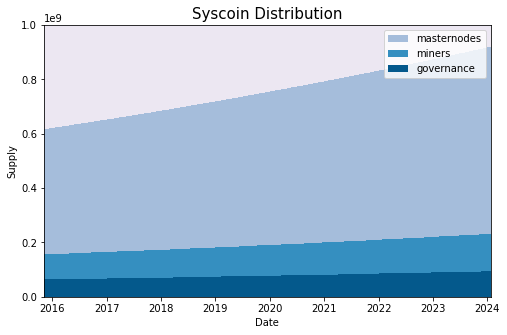

In [27]:
fig = plt.figure(figsize=(8, 5))

cs = plt.contourf(Xdate,Y,Z, cmap='PuBu', levels=[0,1,2,3,4])

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

plt.ylabel("Supply")
plt.xlabel("Date")
plt.title("Syscoin Distribution", fontsize=15)

plt.legend(proxy[1:], ["masternodes", "miners", "governance"])
plt.show()

In [28]:
tx_fee['tx_fee'].values[-1]

2244.0940505014605

In [29]:
import statsmodels.api as sm

N = 12*365

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import random

y = np.log(tx_fee['tx_fee'].values[100:])
x = np.log(np.array(range(1,len(y)+1)))

X = sm.add_constant(x)
regr = sm.OLS(y, X)
fit = regr.fit()
y_hat = fit.fittedvalues
prstd, y_hat_lwr, y_hat_upr = wls_prediction_std(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)

x_new = np.log(np.array(range(2061,2061+N)))
X_p = sm.add_constant(x_new)
pred = fit.get_prediction(X_p)

y_pred = pred.predicted_mean
y_pred_lwr = y_pred - 1.96*prstd[0]
y_pred_upr = y_pred + 1.96*prstd[0]

In [30]:
mc_sim = [np.random.normal(y_pred[k], prstd[0],100) for k in range(0,len(y_pred))]
mc_sim_med = [np.median(mc_sim[k]) for k in range(0,len(y_pred))]
mc_sim_lwr = [np.quantile(mc_sim[k],0.05) for k in range(0,len(y_pred))]
mc_sim_upr = [np.quantile(mc_sim[k],0.95) for k in range(0,len(y_pred))]

In [31]:
sim = mc_sim[0]
for k in range(1,len(y_pred)):
    sim = np.vstack((sim, mc_sim[k]))

In [32]:
dates = [getDate(t) for t in range(0,2062)]
dates_pred = [getDate(t) for t in range(2061,2061+N)]

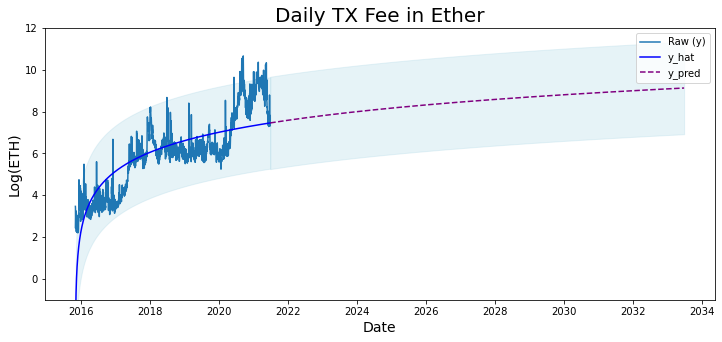

In [41]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plt.plot(dates, y, label="Raw (y)")
plt.plot(dates, y_hat, color='blue', label="y_hat")
plt.fill_between(dates, y_hat_lwr, y_hat_upr, alpha=0.3, color='lightblue')

plt.plot(dates_pred, y_pred, color='purple', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, y_pred_lwr, y_pred_upr, alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log(ETH)", fontsize=14)
plt.ylim(-1,12)
plt.legend();
fig.savefig('../img/eth_daily_tx_fee.png')

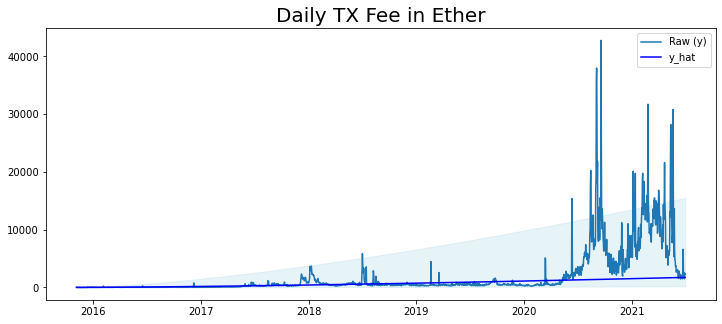

In [34]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
plt.plot(dates, np.exp(y), label="Raw (y)")
plt.plot(dates, np.exp(y_hat), color='blue', label="y_hat")
plt.fill_between(dates, np.exp(y_hat_lwr), np.exp(y_hat_upr), alpha=0.3, color='lightblue')

#plt.plot(dates_pred, np.exp(y_pred), color='blue', linestyle='dashed', label="y_pred")
#plt.fill_between(dates_pred, np.exp(y_pred_lwr), np.exp(y_pred_upr), alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
fig.savefig('../img/eth_daily_tx_fee2.png')
plt.legend();

In [35]:
dates_ = np.append(dates, dates_pred[1:])
y_hat_ = np.append(y_hat, y_pred[1:])
y_hat_lwr_ = np.append(y_hat_lwr, y_pred_lwr[1:])
y_pred_upr_ = np.append(y_hat_upr, y_pred_upr[1:])

est_df = pd.DataFrame({'dates':dates_,
                        'pred':np.cumsum(np.exp(y_hat_)),
                        'pred_lwr':np.cumsum(np.exp(y_hat_lwr_)),
                        'pred_upr':np.cumsum(np.exp(y_pred_upr_))})

est_df = est_df.iloc[0:len(nevm_df)]

Text(0.5, 24.0, 'Date')

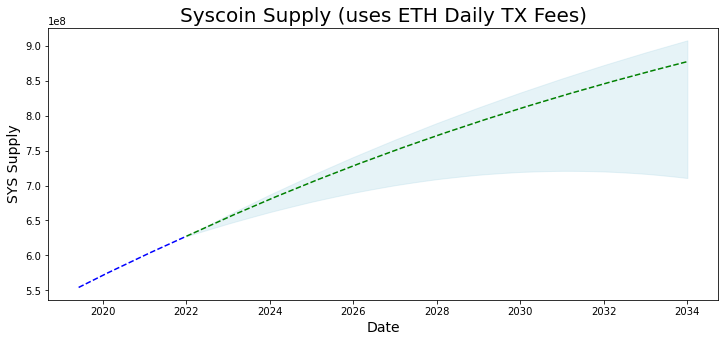

In [36]:
coin_supply_upr = nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = nevm_df['supply_lwr'].values - est_df['pred_upr'].values

fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pow_df['dates'].values, pow_df['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

In [37]:
pred_df = pd.DataFrame({'dates':nevm_med['dates'].values,
                        'pred':nevm_med['supply'].values,
                        'pred_lwr':coin_supply_lwr,
                        'pred_upr':coin_supply_upr})

In [38]:
mo = pd.to_datetime(pred_df['dates'].values).month
da = pd.to_datetime(pred_df['dates'].values).day

indices = []
m = 0
for k in range(0,len(pred_df)):
    if((mo[k] == 1) & (da[k] == 1)): indices.append(k)
    
pred_df.iloc[indices]

,dates,pred,pred_lwr,pred_upr
0,2022-01-01,6.274947e+08,6.274703e+08,6.275041e+08
365,2023-01-01,6.546555e+08,6.455388e+08,6.580786e+08
730,2024-01-01,6.804582e+08,6.620558e+08,6.871161e+08
1096,2025-01-01,7.050379e+08,6.768457e+08,7.147655e+08
1461,2026-01-01,7.283248e+08,6.896808e+08,7.409457e+08
1826,2027-01-01,7.504474e+08,7.004862e+08,7.657995e+08
2191,2028-01-01,7.714639e+08,7.091188e+08,7.893911e+08
2557,2029-01-01,7.914842e+08,7.154496e+08,8.118434e+08
2922,2030-01-01,8.104515e+08,7.194355e+08,8.330906e+08
3287,2031-01-01,8.284705e+08,7.210232e+08,8.532488e+08
